# Chief-deputy Rendezvous and Docking on an Elliptical Orbit
© 2023 Tomohiro Sasaki, All Rights Reserved.

## Import libraries

In [2]:
using Plots; gr()
using LinearAlgebra
using Revise
using CDDP # import CDDP module

using DifferentialEquations
using DataInterpolations
using BenchmarkTools
using Printf

## Define Simulation Setup

In [3]:
# tf = 37000. # final time
tf = 6400. # final time

tN = Int(tf) # number of time steps
dt = tf/tN # time step size
;

## Define Dynamics Model

In [4]:
includet("../src/models/chiefdeputy.jl")
model = ChiefDeputy()

# initial state
x_init = model.x_init
@printf("Initial State: %s \n", x_init)

# final state
x_final = model.x_final
@printf("Final State: %s \n", x_final)

# model dimensions
nx, nu, nw, ny, nv = model.dims.nx, model.dims.nu, model.dims.nw, model.dims.ny, model.dims.nv
@printf("nx: %i, nu: %i, nw: %i, ny: %i, nv: %i \n", nx, nu, nw, ny, nv)

Initial State: [-0.0938926887214051, 0.06820928216330306, 0.03410464108165153, 0.037865035768176944, 0.2084906865487613, 0.10424534327438065] 
Final State: [-0.037596641322261634, 0.02731245586066615, 0.013656227930333074, 0.015161970413423813, 0.08348413138390476, 0.04174206569195238] 


nx: 6, nu: 3, nw: 6, ny: 3, nv: 3 


## Propagate Chief Spacecraft Orbit

In [5]:
Œ, _ = initialize_trajectory(model, tf, tN, model.œ_init, model.fc!)
model.params.Œ = Œ;

In [6]:
X0, U0 = initialize_trajectory(model, tf, tN, x_init, model.f!, U_md=Œ);
Xf, _ = initialize_trajectory(model, tf, tN, x_final, model.f!, U_md=Œ);

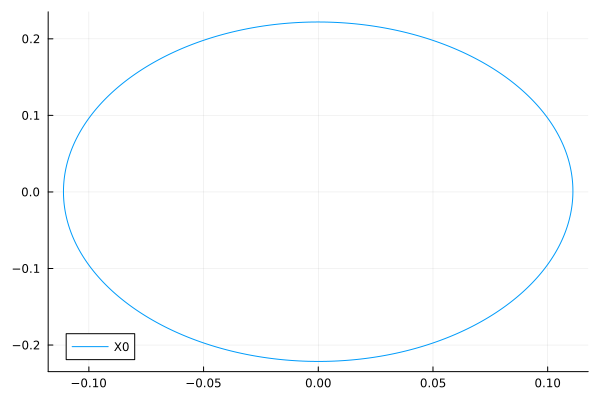

In [7]:
plot(X0[4,:], X0[5,:], label="X0")

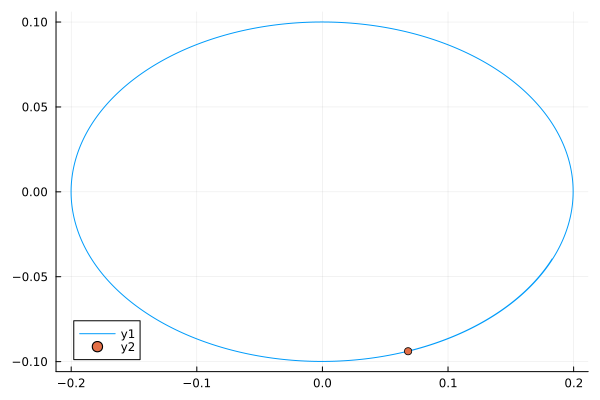

In [8]:
plot(X0[2,:], X0[1,:])
scatter!((X0[2,1], X0[1,1]))

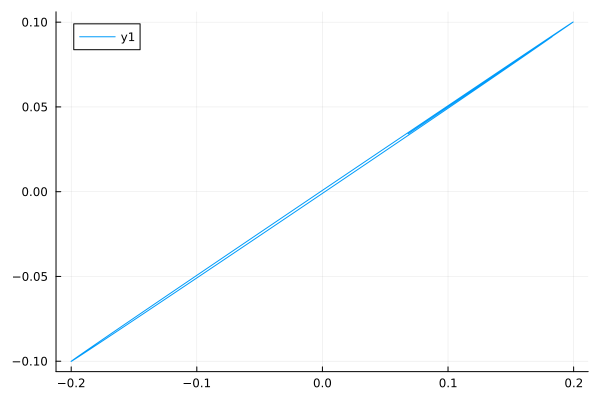

In [9]:
plot(X0[2,:], X0[3,:])

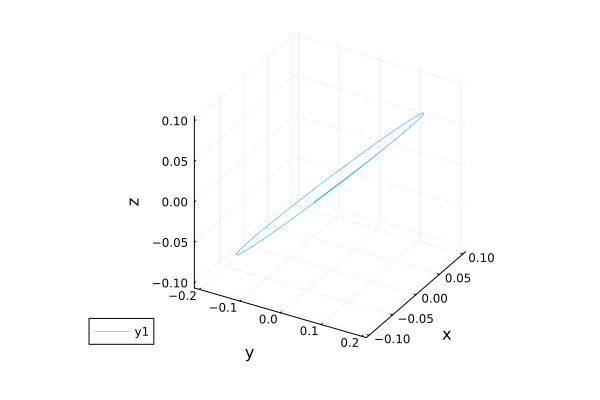

In [10]:
plot(X0[2,:], X0[1,:], X0[3,:], linewidth=0.5)
xlabel!("y")
ylabel!("x")
zlabel!("z")

## Define Cost Functions for Trajecotry Optimization

In [11]:
function ell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+2 * [0; 0; 0]; 1.0e+2 * [0; 0; 0]])
    R = Diagonal(1e+4 * [1; 1; 1])
    if x_ref == nothing
        return x'*Q*x + u'*R*u
    else
        return (x-x_ref)'*Q*(x-x_ref) + u'*R*u
    end
end

function phi_cost(x::Vector; x_ref::Vector=nothing)
    Qf = Diagonal([1e+4 * [1; 1; 1]; 1e+4 * [1; 1; 1]])
    if x_ref == nothing
        return x'*Qf*x
    else
        return (x-x_ref)'*Qf*(x-x_ref)
    end
end

function ∇ₓell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+2 * [0; 0; 0]; 1.0e+2 * [0; 0; 0]])
    R = Diagonal(1e+4 * [1; 1; 1])
    if x_ref == nothing
        return Q*x
    else
        return Q*(x-x_ref)
    end
end

function ∇ᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+2 * [0; 0; 0]; 1.0e+2 * [0; 0; 0]])
    R = Diagonal(1e+4 * [1; 1; 1])
    return R*u
end

function ∇ₓₓell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+2 * [0; 0; 0]; 1.0e+2 * [0; 0; 0]])
    R = Diagonal(1e+4 * [1; 1; 1])
    return Q
end

function ∇ᵤᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+2 * [0; 0; 0]; 1.0e+2 * [0; 0; 0]])
    R = Diagonal(1e+4 * [1; 1; 1])
    return R
end

function ∇ₓᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    return zeros(6,3)
end

function ∇ₓphi_cost(x::Vector; x_ref::Vector=nothing)
    Qf = Diagonal([1e+4 * [1; 1; 1]; 1e+4 * [1; 1; 1]])
    if x_ref == nothing
        return Qf*x
    else
        return Qf*(x-x_ref)
    end
end

function ∇ₓₓphi_cost(x::Vector; x_ref::Vector=nothing)
    Qf = Diagonal([1e+4 * [1; 1; 1]; 1e+4 * [1; 1; 1]])
    return Qf
end


cost_funcs = CostFunction(
    ell=ell_cost,
    ∇ₓell=∇ₓell_cost,
    ∇ᵤell=∇ᵤell_cost,
    ∇ₓₓell=∇ₓₓell_cost,
    ∇ᵤᵤell=∇ᵤᵤell_cost,
    ∇ₓᵤell=∇ₓᵤell_cost,
    phi=phi_cost,
    ∇ₓphi=∇ₓphi_cost,
    ∇ₓₓphi=∇ₓₓphi_cost,
);

## Construct Trajecotry Optimization Problem

In [12]:
dyn_funcs = DynamicsFunction(f! =model.f!, ∇f=model.∇f, ∇²f=model.∇²f, integrator=Tsit5());

prob = DDPProblem(
    model=model, 
    tf=tf, 
    tN=tN, 
    dt=dt, 
    dims=model.dims,
    cost_funcs=cost_funcs,
    dyn_funcs=dyn_funcs,
    x_init=x_init, 
    x_final=x_final, 
    X_ref=nothing,
    U_md=Œ)
J = get_trajectory_cost(X0, U0, prob.X_ref, prob.x_final, cost_funcs.ell, cost_funcs.ϕ, prob.tN, prob.dt) 

378.2241112883344

## Solve Trajectory Optimization Problem


In [13]:

sol = solve_ddp(
    prob, 
    X=nothing, 
    U=nothing, 
    isilqr=true,
    max_ite=10, 
    tol=1e-8,
    reg_param_x=1e-6, 
    reg_param_x_fact=10.0, 
    reg_param_x_lb=1e-20,
    reg_param_u=1e-4, 
    reg_param_u_fact=10.0,
    reg_param_u_lb=1e-20,
    line_search_steps = 5 .^ LinRange(0, -6, 30),
    verbose=true,
    )
    
X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_ddp, U_ddp, J_ddp, gains_ddp = sol.X, sol.U, sol.J, sol.gains;

**************************************************************************************
>>> Start DDP Problem Solver 
**************************************************************************************
iter    objective  
                


0       378.224111,  
                
1       0.031144,  
                


2       0.031131,  
                
3       0.031131,  
                


4       0.031131,  
                
5       0.031131,  
                


6       0.031131,  
                
**************************************************************************************
>>> Successfully Finished DDP Problem Solver <<< 
**************************************************************************************


## Plot Optimized Trajectory

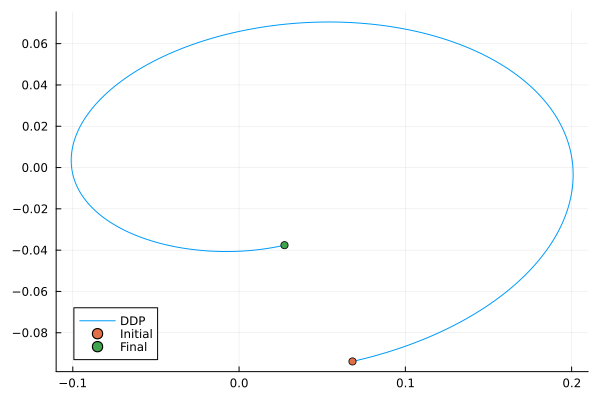

In [14]:
X_ddp, U_ddp, J_ddp, gains_ddp = sol.X, sol.U, sol.J, sol.gains;
plot(X_ddp[2,:], X_ddp[1,:], label="DDP")
scatter!((X0[2,1], X0[1,1]), label="Initial")
scatter!((model.x_final[2], model.x_final[1]), label="Final")

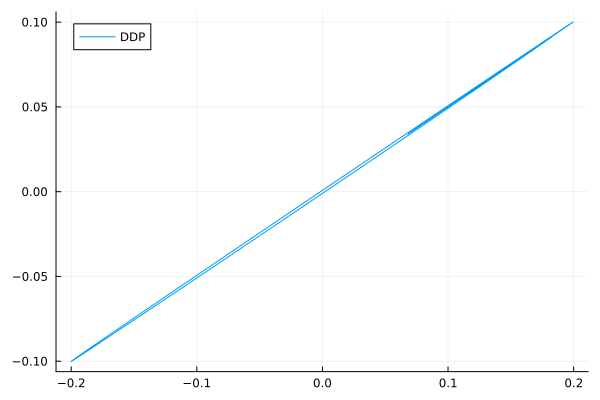

In [15]:
plot(X0[2,:], X0[3,:], label="DDP")

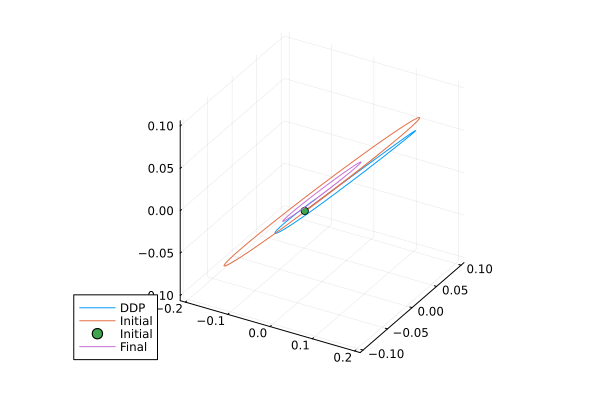

In [16]:
plot(X_ddp[2,:], X_ddp[1,:], X_ddp[3,:], label="DDP")
plot!(X0[2,:], X0[1,:], X0[3,:], label="Initial")
scatter!((X0[2,1], X0[1,1], X0[3,1]), label="Initial")
plot!(Xf[2,:], Xf[1,:], Xf[3,:], label="Final")

## Define Cost Functions for MPPI

In [17]:
function stage_cost(x::Vector, x_ref::Vector)
    Q = Diagonal([1.0e+1 * [0; 0; 0]; 1.0e+1 * [0; 0; 0]])
    if x_ref == nothing
        return x'*Q*x
    else
        return (x-x_ref)'*Q*(x-x_ref) 
    end
end

function terminal_cost(x::Vector, x_ref::Vector)
    Qf = Diagonal([1e+3 * [1; 1; 1]; 1e+3 * [1; 1; 1]])
    if x_ref == nothing
        return x'*Qf*x
    else
        return (x-x_ref)'*Qf*(x-x_ref)
    end
end
;

## Construct MPPI Problem

In [119]:
hN = 50; # horizon length
Ts = 10.0; # sampling time
Tsc = 10.0; # sampling time for control
K = 10 # number of samples
λ = 50.
μ_ctrl = zeros(model.dims.nu)
Σ_ctrl = 1e-13 * Diagonal(ones(model.dims.nu, model.dims.nu))
u = [0.0; 0.0; 0.0]
G = [zeros(3,3); Matrix{Float64}(I(3))]
dist_ctrl = MvNormal(μ_ctrl, Σ_ctrl)

problem = MPPIProblemCPU(
    model,
    tf=Ts*hN,
    tN=hN,
    dt=Ts,
    dims=model.dims,
    cost_funcs=MPPICostFunction(ell=stage_cost, phi=terminal_cost),
    dyn_funcs=MPPIDynamicsFunction(f=model.f, f! =model.f!),
    x_init=x_init,
    x_final=x_final,
    X_ref=X_ddp,
    U_md=Œ,
);

## Simulate MPPI Control

In [169]:
XEst = zeros(nx, tN+1)
XTrue = zeros(nx, tN+1)
X_sol = zeros(nx, tN+1)
U_sol = zeros(nu, tN)

xEst = model.x_init
xTrue = model.x_init
PEst = Diagonal([1e-3*[1; 1; 1]; 1e-5*[1; 1; 1]])
PEst_arr = zeros(nx, nx, tN+1)
PEst_arr[:,:,1] = PEst

XTrue[:,1] = xTrue
XEst[:,1] = xEst
X_sol[:,1] = xEst

u_out = zeros(nu)
U = zeros(nu, hN)
for j in 1:hN
    t = (j-1)*Ts
    U[:,j] = U_ddp(t)
end

params_arr = model.params.arr
dyn_funcs = problem.dyn_funcs


μ_proc = zeros(model.dims.nw)
# Σ_proc = Σ_ctrl
# Σ_proc = G * Σ_ctrl * G' * dt^2
Σ_proc = 1e-12 * Diagonal(ones(model.dims.nw, model.dims.nw))
μ_meas = zeros(model.dims.nv)
Σ_meas = 1e-8 * Diagonal(ones(model.dims.nv, model.dims.nv))
dist_meas = MvNormal(μ_meas, Σ_meas)


ekf_prob = EKFProblem(
    dt,
    model.dims,
    dyn_funcs.f,
    model.h,
    μ_proc,
    μ_meas,
    Σ_proc,
    Σ_meas,
)


# MPPI simulations
for j in 1:tN-100
    t = (j-1) * dt

    # if mod(t, Tsc) == 0
    #     @printf("t: %f\n", t)
    #     problem.x_init = X_sol[:, j]
    #     problem.x_final = X_ddp[:, j+hN]
    #     problem.X_ref = X_ddp[:, j:j+hN]
    #     problem.U_md = Œ[:,j:j+hN]
        
    #     u_out, U = solve_mppi(problem, U=U, K=K, λ=λ, μ=μ_ctrl, Σ=Σ_ctrl, verbose=false)
    # end
    

    # if j+hN <= tN
    #     problem.x_final = X_ddp[:, j+hN]
    # else
    
        
    # end

    

    # solve optimal control problem
    # sol = solve_cddp(prob,max_ite=20, verbose=false);

    # simulate true dynamics
    p = ODEParameter(params=params_arr, U_ref=zeros(3), U_md=Œ(t))
    ode_prob =  ODEProblem(dyn_funcs.f, XTrue[:,j], (0.0,dt), p)
    X_ode = solve(ode_prob, Tsit5())
    XTrue[:,j+1] = X_ode.u[end]

    # take measurements
    z = model.h(XTrue[:,j], zeros(3)) + vec(rand(dist_meas, 1))
    u_noised = vec(rand(dist_ctrl, 1))  + u_out 

    # solve EKF
    # XEst_, PEst_ = solve_EKF(model, ekf_prob, XEst[:,j]+dx_noise, u_out, PEst_arr[:,:,j], z, t=t, u_md=Œ(t))
    XEst_, PEst_ = solve_EKF(model, ekf_prob, XEst[:,j], u_noised, PEst_arr[:,:,j], z, t=t, u_md=Œ(t))
    
    XEst[:,j+1] = copy(XEst_)
    PEst_arr[:,:,j+1] = copy(PEst_)
    X_sol[:, j+1] = copy(XEst_)
    U_sol[:, j] = u_out
end

plot(XTrue[2,:], XTrue[1,:], label="True")
plot!(XEst[2,:], XEst[1,:], label="EKF")


t: 0.000000
δu[:,i,:]: [[3.134906490723208e-7, -3.1850594277216075e-7, 2.7374751741849285e-7] [1.5104720037985248e-7, -8.115811660625235e-7, -2.363329755221172e-7] [2.851615971175482e-9, -6.988080516940678e-8, -1.0508978121102335e-7] [5.653889976392085e-9, -2.2515415452011768e-7, -1.1237387409495204e-8] [-5.223671823817515e-7, -2.2450574260328618e-8, 3.0830505458814653e-7] [-5.289707552967513e-7, -2.2453304446584074e-7, -1.0847074865828842e-7] [-1.7104773004145166e-7, -4.069188657074405e-8, -4.048300076661841e-7] [2.2902357471426163e-7, 2.529905239227528e-7, 2.0971224432968053e-7] [-2.8446755538407013e-7, -4.1955997799740586e-7, -8.036501697439083e-8] [-4.0481422516675533e-7, -2.552878926851918e-7, 3.039304685739272e-7]]


MethodError: MethodError: no method matching (Matrix)(::Vector{Float64})

Closest candidates are:
  (Array{T, N} where T)(::AbstractArray{S, N}) where {S, N}
   @ Core boot.jl:498
  (Matrix)(!Matched::Union{QR, LinearAlgebra.QRCompactWY})
   @ LinearAlgebra /Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/LinearAlgebra/src/qr.jl:449
  (Matrix)(!Matched::AbstractAlgebra.MatrixElem{T}) where T<:AbstractAlgebra.RingElement
   @ AbstractAlgebra ~/.julia/packages/AbstractAlgebra/YkCOC/src/Matrix.jl:7052
  ...


In [60]:
prob = DDPProblem(
    model=model, 
    tf=tf, 
    tN=tN, 
    dt=dt, 
    dims=model.dims,
    cost_funcs=cost_funcs,
    dyn_funcs=dyn_funcs,
    x_init=x_init, 
    x_final=x_final, 
    X_ref=nothing,
    U_md=Œ)
sol = solve_ddp(
    prob, 
    X=nothing, 
    U=nothing, 
    isilqr=true,
    max_ite=10, 
    tol=1e-8,
    reg_param_x=1e-6, 
    reg_param_x_fact=10.0, 
    reg_param_x_lb=1e-20,
    reg_param_u=1e-4, 
    reg_param_u_fact=10.0,
    reg_param_u_lb=1e-20,
    line_search_steps = 5 .^ LinRange(0, -6, 30),
    verbose=true,
    )
    
X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_ddp, U_ddp, J_ddp, gains_ddp = sol.X, sol.U, sol.J, sol.gains;

In [ ]:


using Random 
using Distributions
dist = MvNormal(μ, Σ)
dU = rand(dist, 10, 5)
du = Array(dU[1,:])
for i in 2:size(dU,1)
    du = hcat(du, dU[i,:])
end
# du = hcat(du, dU[i,:])
# du = [du[:,i] for i in 1:size(du,1)]

# Appendix
Obtain orbital elements of chief orbit and stable relative position and velocity


In [159]:
includet("../src/astro_funcs.jl")

μ = 3.986004415e+14
sidereal_day = 86164.0905  # s
r_cubed = μ  * sidereal_day^2 / (4 * pi^2)
Re = 6378e+3
ra = 42000e3
rp = 500e3 + Re
a = (ra + rp) / 2  # a (m) semi-major axis 
e = (ra - rp) / (ra + rp) # e eccentricity
i = 0.05 # i (rad) inclination
Ω = 00.0 * pi / 180 # Ω (rad) right ascension of ascending node
ω = 20.0 * pi / 180 # ω (rad) argument of perigee
M = 00.0 * pi / 180 # M (rad) mean anomaly
MOE = [
    a  
    e
    i
    Ω
    ω
    M
]

# MOE = [46000e3; 0.67; deg2rad(62.8); deg2rad(0); deg2rad(0); deg2rad(0)]
MOE_osc = oscOE2meaOE(MOE, false)
œ_init = MOE2OE_mean(MOE_osc)
@printf("œ_init = %s\n", œ_init)

T_s = 2*pi*sqrt(MOE[1]^3/μ)
@printf("T_s = %s\n", T_s)

n = 1/sqrt(MOE[1]^3/μ)
x_dist_0 = 100
vy0 = get_initial_y_velocity(x_dist_0, n, MOE[2])
x_dist_f = 20
vyf = get_initial_y_velocity(x_dist_f, n, MOE[2])
x_init = [x_dist_0, 0, 2 *x_dist_0, 0., vy0, 0.]
x_final = [x_dist_f, 0, 2 *x_dist_f, 0., vyf, 0.]

@printf("x_init = %s\n", x_init)
@printf("x_final = %s\n", x_final)

r_ECI: [6.459236933035387e6, 2.348037708969936e6, 117453.72374384502]
v_ECI: [-3415.369979024377, 9371.894289258933, 469.1838233301399]
œ_init = [6.873777579835884e6, -0.002229583937249078, 6.8640542098738884e10, 0.05001634091439573, 0.00026150952573454346, 0.34880515073050467]
œ_init = [6.873777579835884e6, -0.002229583937249078, 6.8640542098738884e10, 0.05001634091439573, 0.00026150952573454346, 0.34880515073050467]
T_s = 38022.102451996536
x_init = [100.0, 0.0, 200.0, 0.0, -0.2295262475850926, 0.0]
x_final = [20.0, 0.0, 40.0, 0.0, -0.04590524951701853, 0.0]


In [89]:
T_s = 2*pi*sqrt(MOE[1]^3/μ)

38213.82405513386

In [223]:
a = 7420e3
T_s = 2*pi*sqrt(a^3/μ)

6360.8746690473645

In [136]:
includet("../src/astro_funcs.jl")
μ = 3.986004415e+14
a = 7100e3
e = 0.05
i = 45. * pi / 180 # i (rad) inclination
Ω = 0. * pi / 180 # Ω (rad) right ascension of ascending node
ω = -20. * pi / 180 # ω (rad) argument of perigee
ν = 20.0 * pi / 180 # M (rad) mean anomaly
MOE = [
    a  
    e
    i
    Ω
    ω
    ν
]

# MOE = [46000e3; 0.67; deg2rad(62.8); deg2rad(0); deg2rad(0); deg2rad(0)]
# œ_init_mean = MOE2OE(MOE)
# œ_init = oscOE2meaOE(œ_init_mean, false)

œ_init = MOE2OE_true(MOE)
@printf("œ_init = %s\n", œ_init)

T_s = 2*pi*sqrt(MOE[1]^3/μ)
@printf("T_s = %s\n", T_s)

n = 1/sqrt(MOE[1]^3/μ)
x_dist = 1250
get_initial_y_velocity(x_dist, n, MOE[2])

r_ECI: [6.764425942881095e6, -2.3283064365386963e-10, 0.0]
v_ECI: [128.2935876689544, 5554.034459113062, 5554.0344591130615]
œ_init = [6.764425942881095e6, 128.2935876689542, 5.313179817033652e10, 0.7853981633974483, 0.0, 0.0]
T_s = 5953.858428568329


-2.850133358359352

In [114]:
Re = 6378.137e3 # earth's radius
    μ = 3.986004415e14 # gravitational parameter around earth
    J2 =1.08262668e-3 # J2 perturbation constant
    g = 9.8067 # gravitational acceleration
    k_J2 = 3 * J2 * μ * Re^2 / 2 # J2 perturbation constant
    ux = 0
k_J2 = 3 * J2 * μ * Re^2 / 2 


k_J2 = 3 *  3.986004415e14 * 6378.137e3^2 * 1.08262668e-3 / 2

2.63327033704725e25

In [83]:
p = 1.1132 * 6378e3
# h_ang = sqrt(μ * p)
h_vec = [0.5275, -0.5275, 0.7461] * 6378e3 * 7.90538e3
norm(h_vec)

5.3197290919844864e10